## 라이브러리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

plt.rc("font", family = "Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False

---

## 데이터 불러오기

데이터분석가의 프로젝트(데.프)의 패션 이커머스 로그 데이터

- 해당 서비스는 가상의 패션 이커머스 서비스
- 다양한 상품들이 등록되어있으며 유저는 로그인 이후 상품을 조회하여 구매할 수 있음
- 마음에 드는 상품을 담을 수 있는 장바구니 시스템도 있음
- 내부 추천 알고리즘이 적용되어 있어, 유저들은 추천된 상품을 조회할 수도 있음

In [2]:
# 데이터 불러오기

# 유저 정보 데이터
users = pd.read_csv("./data/users.csv")
# 판매자 정보 데이터
vendors = pd.read_csv("./data/vendors.csv")
# 상품 정보 데이터
products = pd.read_csv("./data/products.csv")
# 유저 로그인 로그 데이터
login_logs = pd.read_csv("./data/login_logs.csv")
# 유저 컨텐츠 시청 로그 데이터
product_view_logs = pd.read_csv("./data/product_view_logs.csv")
# 유저 장바구니 로그 데이터
cart_logs = pd.read_csv("./data/cart_logs.csv")
# 유저 상품 구매 로그 데이터
purchase_logs = pd.read_csv("./data/purchase_logs.csv")
# 구매 로그 상세 내역 데이터
order_details = pd.read_csv("./data/order_details.csv")

In [3]:
# 유저 정보 데이터
users.head(2)

,user_id,device_type,country,signup_date
0,1,Mobile,India,2019-08-10 03:37:07
1,2,Mobile,United States,2018-05-08 06:04:25


- user_id: 유저 고유 인덱스
- device_type: 가입 시 기기 타입
- country: 가입 시점 국가
- signup_date: 가입 시점 시간

In [4]:
# 판매자 정보 데이터
vendors.head(2)

,vendor_id,vendor_rating
0,1,4.6
1,2,4.9


- vendor_id: 판매자 고유 인덱스
- vendor_rating: 판매자 평점

In [5]:
# 상품 정보 데이터
products.head(2)

,product_id,product_name,category,price,vendor_id,rating,review_count
0,1,sell,Watches,396.83,1,4.9,447
1,2,after,Outerwear,140.25,1,4.5,507


- product_id: 상품 고유 인덱스
- product_name: 상품 이름
- category: 상품 카테고리
- price: 상품 가격
- vendor_id: 판매자 고유 인덱스 [vendors]
- rating: 상품 평점
- review_count: 상품 리뷰 갯수

In [6]:
# 유저 로그인 로그 데이터
login_logs.head(2)

,log_id,user_id,login_time,device_type
0,289888bc-1030-4f4b-8b63-290746f3effd,2533,2018-05-03 13:50:07,Desktop
1,87ae4d39-27b4-42a2-a46e-ac931dd2152f,4065,2018-05-04 11:44:29,Mobile


- log_id: 로그인 고유 인덱스
- user_id: 유저 고유 인덱스 [users]
- login_time: 로그인 시점 시간
- device_type: 로그인 시점 기기 타입

In [7]:
# 유저 컨텐츠 시청 로그 데이터
product_view_logs.head(2)

,log_id,user_id,product_id,view_time,device_type,category,is_recommended
0,0676dd43-c34f-4f5d-8b95-0a2c977605a2,243,2,2018-05-07 06:06:16,Desktop,Outerwear,False
1,0676dd43-c34f-4f5d-8b95-0a2c977605a2,243,990,2018-05-07 06:18:55,Desktop,Watches,False


- log_id: 로그인 고유 인덱스 [login_logs]
- user_id: 유저 고유 인덱스 [users]
- product_id: 상품 고유 인덱스 [products]
- view_time: 상품 조회 시점 시간
- device_type: 조회 시점 접속 기기
- category: 상품 카테고리
- is_recommended: 추천 알고리즘에 의해 추천받은 상품 여부

In [8]:
# 유저 장바구니 로그 데이터
cart_logs.head(2)

,log_id,user_id,product_id,add_to_cart_time,quantity,device_type,is_recommended
0,0676dd43-c34f-4f5d-8b95-0a2c977605a2,243,2,2018-05-07 06:38:23,1,Desktop,False
1,2012a65f-5d83-49cc-a55d-fdc419e81cc2,2533,856,2018-05-13 06:17:55,1,Desktop,False


- log_id: 로그인 고유 인덱스 [login_logs]
- user_id: 유저 고유 인덱스 [users]
- product_id: 상품 고유 인덱스 [products]
- add_to_cart_time: 장바구니 등록 시점 시간
- quantity: 상품 등록 수량
- device_type: 장바구니 시점 접속 기기
- is_recommended: 추천 알고리즘에 의해 추천받은 상품 여부

In [9]:
# 유저 상품 구매 로그 데이터
purchase_logs.head(2)

,purchase_id,user_id,log_id,purchase_time,total_amount,payment_method,shipping_address
0,96594d71-5ebf-4104-a65d-c65790255d94,243,0676dd43-c34f-4f5d-8b95-0a2c977605a2,2018-05-07 06:39:28,140.25,Credit Card,"4338 Hill Glen\nNorth Sandramouth, NH 08525"
1,60a67b23-d21d-4cad-b9a0-9f2e8dd1276c,2533,2012a65f-5d83-49cc-a55d-fdc419e81cc2,2018-05-13 06:25:26,52.68,Credit Card,Unit 0819 Box 1813\nDPO AP 77037


- purchase_id: 구매 로그 고유 인덱스
- user_id: 유저 고유 인덱스 [users]
- log_id: 로그인 고유 인덱스 [login_logs]
- purchase_time: 구매 시점 시간
- total_amount: 총 구매 금액
- pay_amount: 결제 방식(Credit Card, Paypal)
- shipping_address: 배송지 정보

In [10]:
# 구매 로그 상세 내역 데이터
order_details.head(2)

,purchase_id,product_id,quantity,unit_price,subtotal
0,b7783a5b-5ae8-4c4d-a7fb-cca642da5258,1052,5,60.65,303.25
1,b7783a5b-5ae8-4c4d-a7fb-cca642da5258,1969,2,38.79,77.58


- purchase_id: 구매 로그 고유 인덱스 [purchase_logs]
- product_id: 상품 고유 인덱스 [products]
- quantity: 상품 수량
- unit_price: 개당 단가
- subtotal: 상품별 총 금액(수량*단가)

---

## 데이터 전처리

### 결측치 확인

In [11]:
# 데이터프레임 목록과 이름
dataframes = {
    "users": users,
    "vendors": vendors,
    "products": products,
    "login_logs": login_logs,
    "product_view_logs": product_view_logs,
    "cart_logs": cart_logs,
    "purchase_logs": purchase_logs,
    "order_details": order_details
}

In [12]:
# info 출력
for name, df in dataframes.items():
    print(f"\n----- {name} info -----")
    df.info()


----- users info -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5041 entries, 0 to 5040
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      5041 non-null   int64 
 1   device_type  5041 non-null   object
 2   country      5041 non-null   object
 3   signup_date  5041 non-null   object
dtypes: int64(1), object(3)
memory usage: 157.7+ KB

----- vendors info -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   vendor_id      400 non-null    int64  
 1   vendor_rating  400 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 6.4 KB

----- products info -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----

- users: 결측치 없음(5041 rows)
- vendors: 결측치 없음(400 rows)
- products: 결측치 없음(2000 rows)
- login_logs: 결측치 없음(761174 rows)
- products_view_logs: 결측치 없음(536403 rows)
- cart_logs: 결측치 없음(164742 rows)
- purchase_logs: 결측치 없음(58716 rows)
- order_details: 결측치 없음(76763 rows)

### 날짜 타입 변환

In [13]:
# 날짜 타입 변환
users['signup_date'] = pd.to_datetime(users['signup_date'])
login_logs['login_time'] = pd.to_datetime(login_logs['login_time'])
product_view_logs['view_time'] = pd.to_datetime(product_view_logs['view_time'])
cart_logs['add_to_cart_time'] = pd.to_datetime(cart_logs['add_to_cart_time'])
purchase_logs['purchase_time'] = pd.to_datetime(purchase_logs['purchase_time'])

날짜 데이터가 object 타입으로 되어있는 것을 확인 후 날짜 타입으로 변환 (5 columns)

In [14]:
# info 출력
for name, df in dataframes.items():
    print(f"\n----- {name} info -----")
    df.info()


----- users info -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5041 entries, 0 to 5040
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      5041 non-null   int64         
 1   device_type  5041 non-null   object        
 2   country      5041 non-null   object        
 3   signup_date  5041 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 157.7+ KB

----- vendors info -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   vendor_id      400 non-null    int64  
 1   vendor_rating  400 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 6.4 KB

----- products info -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column     

In [15]:
# describe 출력
for name, df in dataframes.items():
    print(f"\n----- {name} describe -----")
    print(df.describe())


----- users describe -----
           user_id                    signup_date
count  5041.000000                           5041
mean   2521.000000  2021-02-22 13:58:09.855187200
min       1.000000            2018-05-01 17:51:28
25%    1261.000000            2019-09-29 18:59:19
50%    2521.000000            2021-02-22 20:47:31
75%    3781.000000            2022-07-20 22:31:14
max    5041.000000            2023-12-30 07:10:39
std    1455.355684                            NaN

----- vendors describe -----
        vendor_id  vendor_rating
count  400.000000     400.000000
mean   200.500000       4.139250
std    115.614301       0.677186
min      1.000000       2.100000
25%    100.750000       3.800000
50%    200.500000       4.300000
75%    300.250000       4.700000
max    400.000000       5.000000

----- products describe -----
        product_id        price    vendor_id       rating  review_count
count  2000.000000  2000.000000  2000.000000  2000.000000   2000.000000
mean   1000.500000  

데이터 기간: 2018.05.01.~2023.12.31.

### 중복값 확인

In [16]:
# 각 데이터프레임에 대해 중복값 확인
for name, df in dataframes.items():
    duplicate_count = df.duplicated(keep=False).sum()
    if duplicate_count > 0:
        print(f"\n--- {name} 데이터프레임의 중복값 확인 ---")
        print(f"중복된 행의 개수: {duplicate_count}")
        print(df[df.duplicated(keep=False)].head())


--- product_view_logs 데이터프레임의 중복값 확인 ---
중복된 행의 개수: 2
                                    log_id  user_id  product_id  \
6855  984a9670-c8ef-4966-a4e6-5c7f0882e9fc      147        1103   
6856  984a9670-c8ef-4966-a4e6-5c7f0882e9fc      147        1103   

               view_time device_type   category  is_recommended  
6855 2019-03-23 21:28:41     Desktop  Outerwear           False  
6856 2019-03-23 21:28:41     Desktop  Outerwear           False  

--- order_details 데이터프레임의 중복값 확인 ---
중복된 행의 개수: 26
                                purchase_id  product_id  quantity  unit_price  \
998    239acb73-e6dd-4d77-b395-b65e1d78d5eb        1425         3       35.17   
1000   239acb73-e6dd-4d77-b395-b65e1d78d5eb        1425         3       35.17   
12249  e86f34c7-0642-4958-bc3b-b72cba88f999        1948         1       97.54   
12250  e86f34c7-0642-4958-bc3b-b72cba88f999        1948         1       97.54   
17862  f0f23663-d016-4f87-b87f-a01ffbf1b5e4        1719         3       23.96   

      

- product_view_logs: 2개의 중복 데이터가 발견됨. 빠르게 연속 클릭한 경우일 수 있으나 시간 차이가 없으므로 1회 클릭으로 간주하여 삭제
- order_details: 동일한 상품이 동일한 수량으로 하나의 purchase_id에 두 번 기록된 경우 시스템 오류로 판단하여 삭제

In [17]:
# 중복 데이터 삭제
product_view_logs = product_view_logs.drop_duplicates(keep="first").copy()
order_details = order_details.drop_duplicates(keep="first").copy()

print(len(product_view_logs), len(order_details))

536402 76750


- products_view_logs: 536403 rows → 536402 rows (1 row deleted)
- order_details: 76763 rows → 76750 rows (13 rows deleted)

### 이상치 확인

In [18]:
# 각 데이터프레임에 대해 이상치 확인
for name, df in dataframes.items():
    numeric_columns = df.select_dtypes(include=['number']).columns # 숫자 타입

    for col in numeric_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

        if not outliers.empty:
            print(f"\n--- {name} 데이터프레임의 이상치 확인 ---")
            print(f"'{col}' 열의 이상치 개수: {len(outliers)}")
            print(outliers[[col]].head())


--- vendors 데이터프레임의 이상치 확인 ---
'vendor_rating' 열의 이상치 개수: 14
     vendor_rating
70             2.1
104            2.1
138            2.3
146            2.4
187            2.2

--- products 데이터프레임의 이상치 확인 ---
'price' 열의 이상치 개수: 297
    price
0  396.83
1  140.25
2  469.67
3  268.79
4  350.92

--- products 데이터프레임의 이상치 확인 ---
'rating' 열의 이상치 개수: 39
     rating
197     2.1
398     2.0
401     1.8
402     1.8
403     1.8

--- purchase_logs 데이터프레임의 이상치 확인 ---
'total_amount' 열의 이상치 개수: 7397
    total_amount
14       4871.50
34       1594.95
35       1079.91
39        772.28
59       1086.45

--- order_details 데이터프레임의 이상치 확인 ---
'unit_price' 열의 이상치 개수: 11194
    unit_price
19      127.76
20      321.75
23      322.01
37      156.12
38      164.38

--- order_details 데이터프레임의 이상치 확인 ---
'subtotal' 열의 이상치 개수: 8972
    subtotal
19    638.80
20   1287.00
23   1288.04
37    468.36
42   3785.96


- 이상치로 탐지된 항목들은 평점과 가격에 관련된 열임
- 실제로 매우 낮은 평점을 받은 판매자나 상품이 존재할 수 있으며, 상품 가격도 다양할 수 있음
- 따라서 이 값들은 이상치로 판단하지 않고 분석을 진행하기로 결정

---

## 데이터 시각화

### 카테고리별 주문 건수 및 조회 수

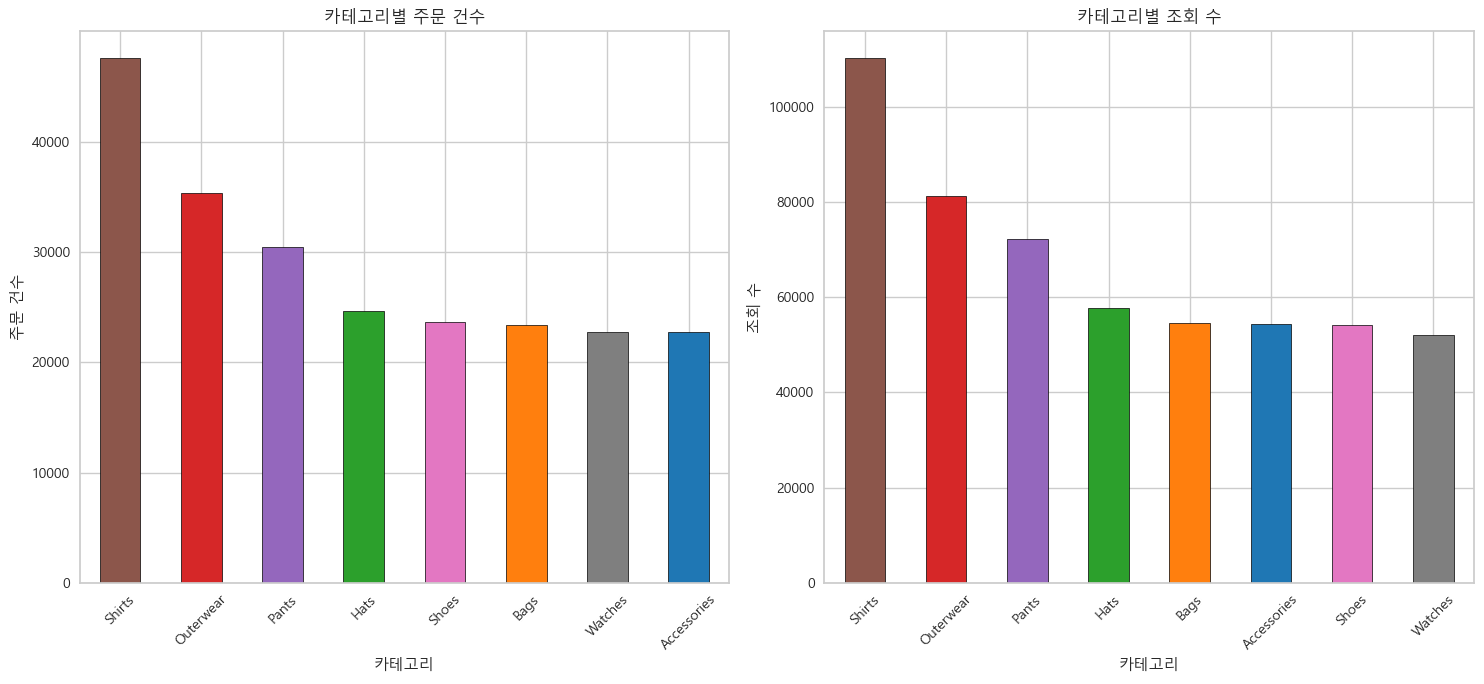

In [19]:
# 테이블 병합
# purchase_logs와 order_details를 purchase_id 기준으로 병합
purchase_order_details = pd.merge(purchase_logs, order_details, on='purchase_id', how='inner')
# 병합된 데이터에 products 테이블을 product_id 기준으로 추가 병합
full_data = pd.merge(purchase_order_details, products, on='product_id', how='inner')

# 카테고리별 구매 수량 계산
category_counts = full_data.groupby('category')['quantity'].sum().sort_values(ascending=False)

# 카테고리별 조회 수 계산
category_views = product_view_logs['category'].value_counts().sort_values(ascending=False)

# 카테고리별 색상 지정
categories = category_counts.index.union(category_views.index)  # 두 데이터프레임의 카테고리 합집합
colors = plt.cm.tab10.colors
color_dict = {category: colors[i % len(colors)] for i, category in enumerate(categories)}

# 가로로 나란히 바 차트 시각화
plt.figure(figsize=(15, 7))

# 카테고리별 구매 수량 바 차트
plt.subplot(1, 2, 1)
category_counts.plot(kind='bar', color=[color_dict[cat] for cat in category_counts.index], edgecolor='black', linewidth=0.5)
plt.title('카테고리별 주문 건수')
plt.xlabel('카테고리')
plt.ylabel('주문 건수')
plt.xticks(rotation=45)

# 카테고리별 조회 수 바 차트
plt.subplot(1, 2, 2)
category_views.plot(kind='bar', color=[color_dict[cat] for cat in category_views.index], edgecolor='black', linewidth=0.5)
plt.title('카테고리별 조회 수')
plt.xlabel('카테고리')
plt.ylabel('조회 수')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('./savefig/00_카테고리별_주문건수_조회수.png')

### 고객 로그인 빈도

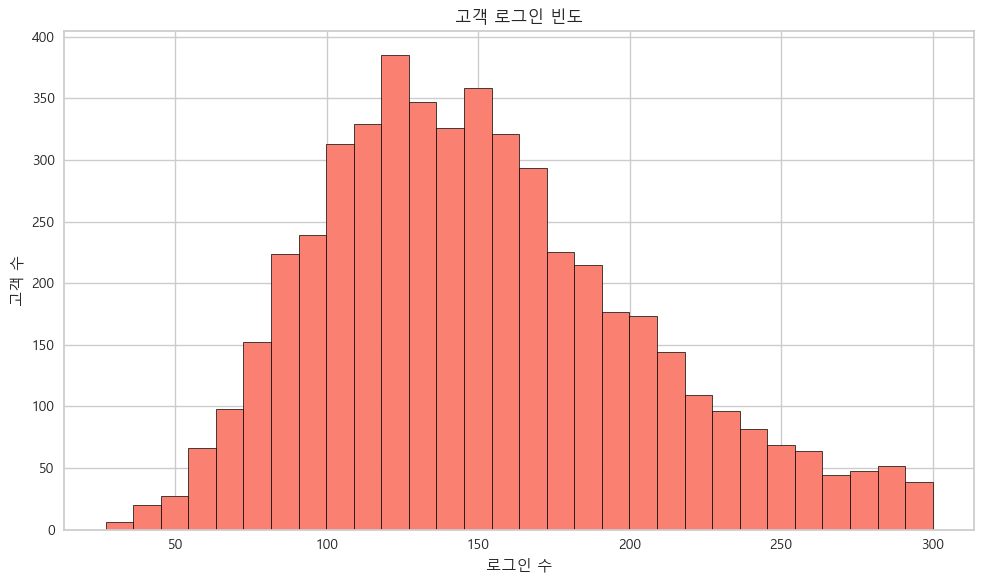

In [20]:
# 각 고객의 로그인 횟수 계산
login_counts = login_logs['user_id'].value_counts()

# 히스토그램 시각화
plt.figure(figsize=(10, 6))
plt.hist(login_counts, bins=30, color='salmon', edgecolor='black', linewidth=0.5)
plt.title('고객 로그인 빈도')
plt.xlabel('로그인 수')
plt.ylabel('고객 수')
plt.tight_layout()
plt.savefig('./savefig/00_고객_로그인_빈도.png')

### 카테고리별 판매량 추이

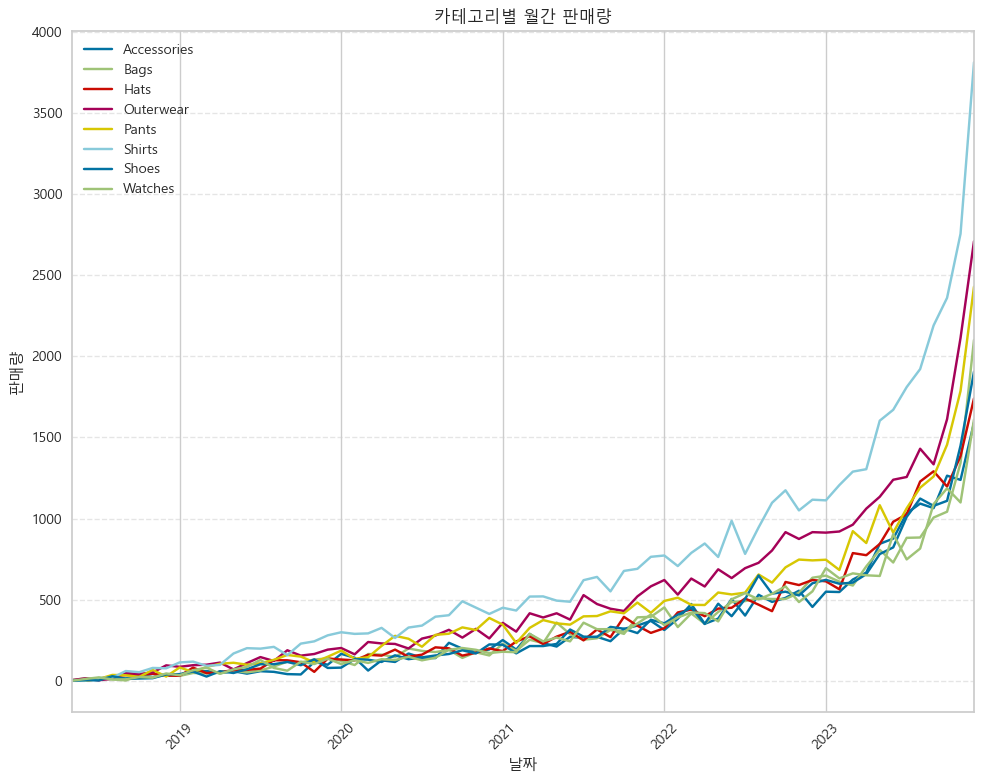

In [21]:
# 연도와 월 추출
purchase_logs['year_month'] = purchase_logs['purchase_time'].dt.to_period('M')

# purchase_logs와 order_details 테이블 병합
purchase_order_details = pd.merge(purchase_logs, order_details, on='purchase_id', how='inner')

# 병합된 데이터에 products 테이블 병합
full_data = pd.merge(purchase_order_details, products, on='product_id', how='inner')

# 카테고리별 월간 판매량 계산
monthly_sales = full_data.groupby(['year_month', 'category'])['quantity'].sum().unstack().fillna(0)

# 라인 차트 시각화
monthly_sales.plot(kind='line', figsize=(10, 8))
plt.title('카테고리별 월간 판매량')
plt.xlabel('날짜')
plt.ylabel('판매량')
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('./savefig/00_카테고리별_월간_판매량.png')

### 제품 평점과 판매량 상관관계

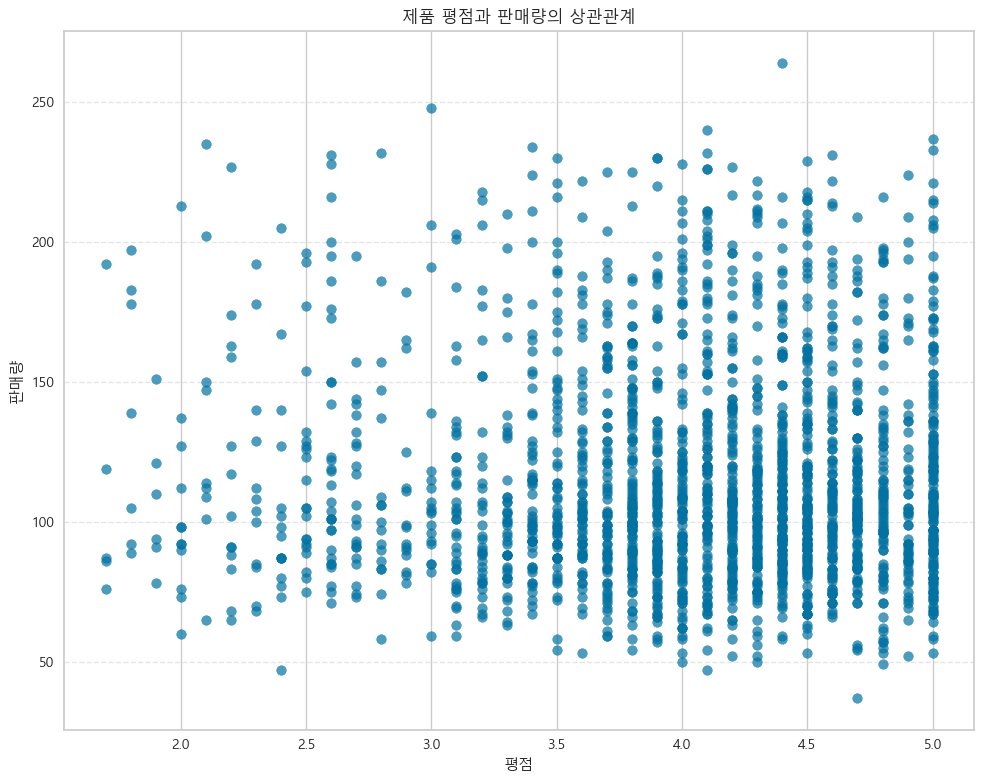

In [22]:
# purchase_logs와 order_details 테이블 병합
purchase_order_details = pd.merge(purchase_logs, order_details, on='purchase_id', how='inner')

# 각 제품의 총 판매량 계산
product_sales = purchase_order_details.groupby('product_id')['quantity'].sum().reset_index()

# 제품 정보와 판매량을 병합하여 평점과 판매량 데이터 생성
product_data = pd.merge(products[['product_id', 'rating']], product_sales, on='product_id', how='inner')

# 산점도 시각화
plt.figure(figsize=(10, 8))
plt.scatter(product_data['rating'], product_data['quantity'], alpha=0.7)
plt.title('제품 평점과 판매량의 상관관계')
plt.xlabel('평점')
plt.ylabel('판매량')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('./savefig/00_제품평점_판매량.png')

## 주요 지표

### 매출, 주문건수, ARPPU, AOV

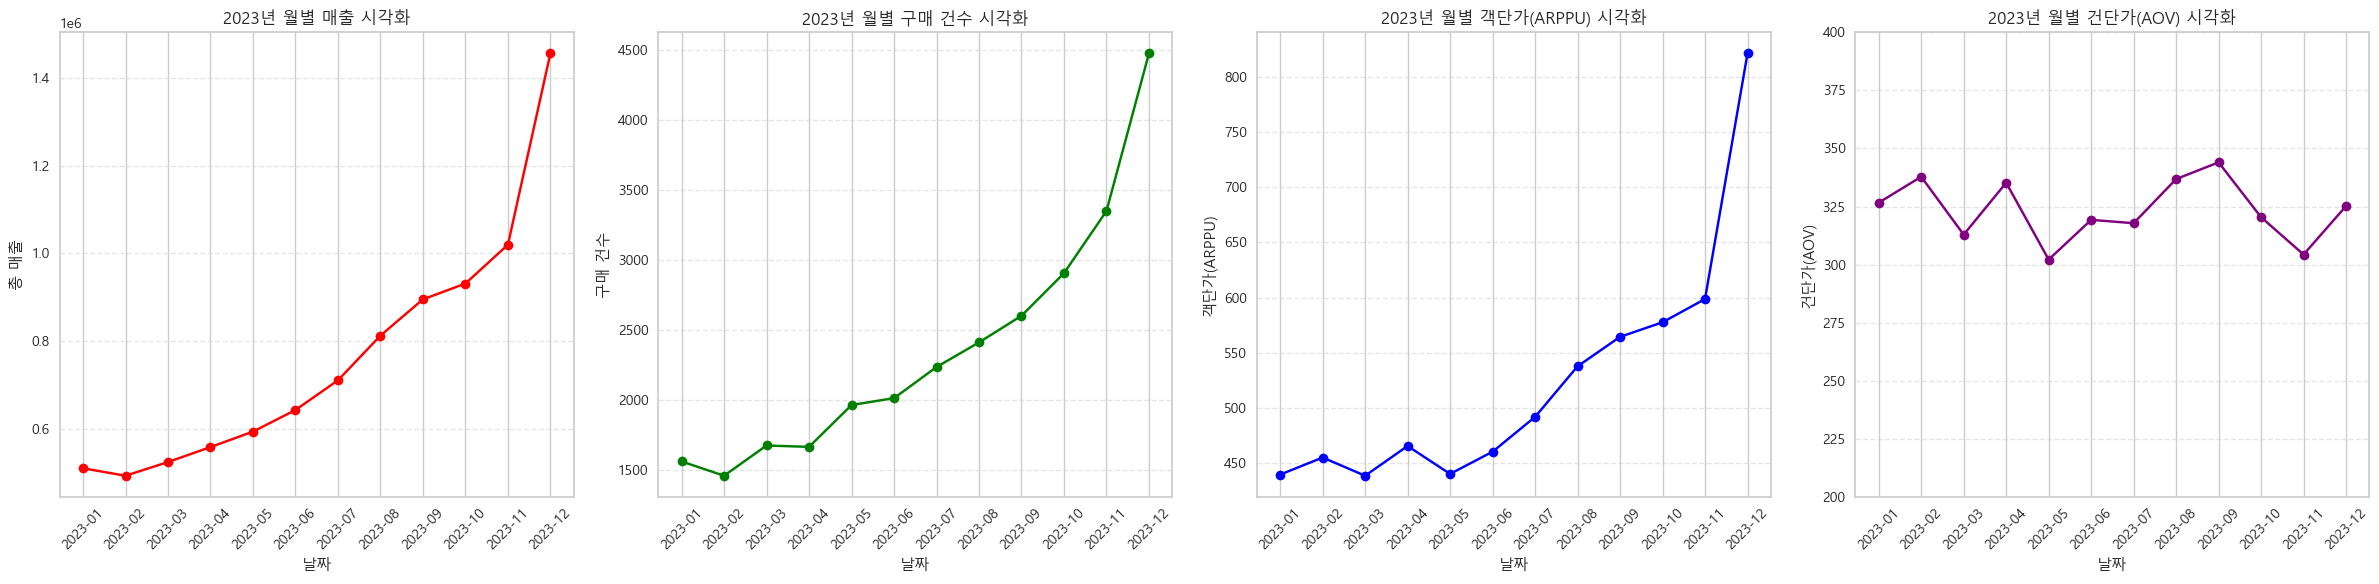

In [23]:
# 날짜 형식 변환 및 월 단위 컬럼 추가
purchase_logs['year_month'] = purchase_logs['purchase_time'].dt.to_period('M')

# 2023년 데이터 필터링
filtered_data = purchase_logs[(purchase_logs['year_month'] >= '2023-01') & (purchase_logs['year_month'] <= '2023-12')]

# 월별 매출, 구매 건수, 주문 고객 수 계산
monthly_sales = filtered_data.groupby('year_month')['total_amount'].sum()
monthly_purchases = filtered_data.groupby('year_month')['purchase_id'].count()
monthly_unique_customers = filtered_data.groupby('year_month')['user_id'].nunique()

# 월별 객단가(ARPPU) 계산 (총 매출 / 주문 고객 수)
monthly_arppu = monthly_sales / monthly_unique_customers

# 월별 건단가(AOV) 계산 (총 매출 / 주문 건수)
monthly_aov = monthly_sales / monthly_purchases

# 그래프 그리기
plt.figure(figsize=(24, 6))

# 월별 매출 그래프
plt.subplot(1, 4, 1)
plt.plot(monthly_sales.index.astype(str), monthly_sales.values, color='red', marker='o')
plt.title('2023년 월별 매출 시각화')
plt.xlabel('날짜')
plt.ylabel('총 매출')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# 월별 구매 건수 그래프
plt.subplot(1, 4, 2)
plt.plot(monthly_purchases.index.astype(str), monthly_purchases.values, color='green', marker='o')
plt.title('2023년 월별 구매 건수 시각화')
plt.xlabel('날짜')
plt.ylabel('구매 건수')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# 월별 객단가(ARPPU) 그래프
plt.subplot(1, 4, 3)
plt.plot(monthly_arppu.index.astype(str), monthly_arppu.values, color='blue', marker='o')
plt.title('2023년 월별 객단가(ARPPU) 시각화')
plt.xlabel('날짜')
plt.ylabel('객단가(ARPPU)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# 월별 건단가(AOV) 그래프
plt.subplot(1, 4, 4)
plt.plot(monthly_aov.index.astype(str), monthly_aov.values, color='purple', marker='o')
plt.title('2023년 월별 건단가(AOV) 시각화')
plt.xlabel('날짜')
plt.ylabel('건단가(AOV)')
plt.ylim(200,400)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# 그래프 표시
plt.tight_layout()
plt.savefig('./savefig/01_2023년_구매지표.png')

### DAU, WAU, MAU, Stickiness
활성 사용자 기준: 로그인

In [24]:
# DAU, WAU, MAU, Stickiness 함수
def get_user_metrics(df, target_date):
    # 날짜 추출
    df['date'] = df['login_time'].dt.date
    
    # 타겟 날짜 타입 변환
    target_date = pd.to_datetime(target_date).date()

    # DAU 계산
    dau = df[df['date'] == target_date]['user_id'].nunique()

    # WAU 계산 (7 days)
    start_week = target_date - pd.Timedelta(days=6)
    wau = df[(df['date'] >= start_week) & (df['date'] <= target_date)]['user_id'].nunique()

    # MAU 계산 (30 days)
    start_month = target_date - pd.Timedelta(days=29)
    mau = df[(df['date'] >= start_month) & (df['date'] <= target_date)]['user_id'].nunique()
    
    return {'DAU': dau, 'WAU': wau, 'MAU': mau}

In [25]:
# 월별 DAU, WAU, MAU 시각화 함수
def get_monthly_user_plot(df):
    metrics_data = []
    
    # 2023년 각 월의 1일 기준으로 DAU, WAU, MAU 계산
    for month in range(1, 13):
        single_date = pd.Timestamp(f'2023-{month:02d}-01')
        metrics = get_user_metrics(df, single_date)
        metrics['date'] = single_date
        metrics_data.append(metrics)
    
    # 데이터프레임으로 변환
    metrics_df = pd.DataFrame(metrics_data)

    # 각각의 그래프 그리기
    plt.figure(figsize=(18, 6))

    # DAU 그래프
    plt.subplot(1, 3, 1)
    plt.plot(metrics_df['date'], metrics_df['DAU'], label='DAU', color='red', marker='o', markersize=6)
    plt.title('2023년 월별 일일 활성 사용자 (DAU)')
    plt.xlabel('날짜')
    plt.ylabel('사용자 수')
    plt.ylim(0,1500)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.legend()

    # WAU 그래프
    plt.subplot(1, 3, 2)
    plt.plot(metrics_df['date'], metrics_df['WAU'], label='WAU', color='green', marker='o', markersize=6)
    plt.title('2023년 월별 주간 활성 사용자 (WAU)')
    plt.xlabel('날짜')
    plt.ylabel('사용자 수')
    plt.ylim(2000,4000)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.legend()

    # MAU 그래프
    plt.subplot(1, 3, 3)
    plt.plot(metrics_df['date'], metrics_df['MAU'], label='MAU', color='blue', marker='o', markersize=6)
    plt.title('2023년 월별 월간 활성 사용자 (MAU)')
    plt.xlabel('날짜')
    plt.ylabel('사용자 수')
    plt.ylim(3000,5000)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.legend()

    plt.tight_layout()
    plt.savefig('./savefig/02_2023년_활성사용자수_개별.png')

In [26]:
# DAU, WAU, MAU 결합 시각화 함수
def get_combined_user_plot(df):
    metrics_data = []
    
    # 2023년 각 월의 1일 기준으로 DAU, WAU, MAU 계산
    for month in range(1, 13):
        single_date = pd.Timestamp(f'2023-{month:02d}-01')
        metrics = get_user_metrics(df, single_date)
        metrics['date'] = single_date
        metrics_data.append(metrics)
    
    # 데이터프레임으로 변환
    metrics_df = pd.DataFrame(metrics_data)

    # 결합 그래프 그리기
    plt.figure(figsize=(10, 8))
    plt.plot(metrics_df['date'], metrics_df['DAU'], label='DAU', color='red', marker='o')
    plt.plot(metrics_df['date'], metrics_df['WAU'], label='WAU', color='green', marker='o')
    plt.plot(metrics_df['date'], metrics_df['MAU'], label='MAU', color='blue', marker='o')

    plt.title('2023년 월별 활성 사용자 지표 (DAU, WAU, MAU)')
    plt.xlabel('날짜')
    plt.ylabel('사용자 수')
    plt.ylim(0, 5000)
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig('./savefig/03_2023년_활성사용자수_결합.png')

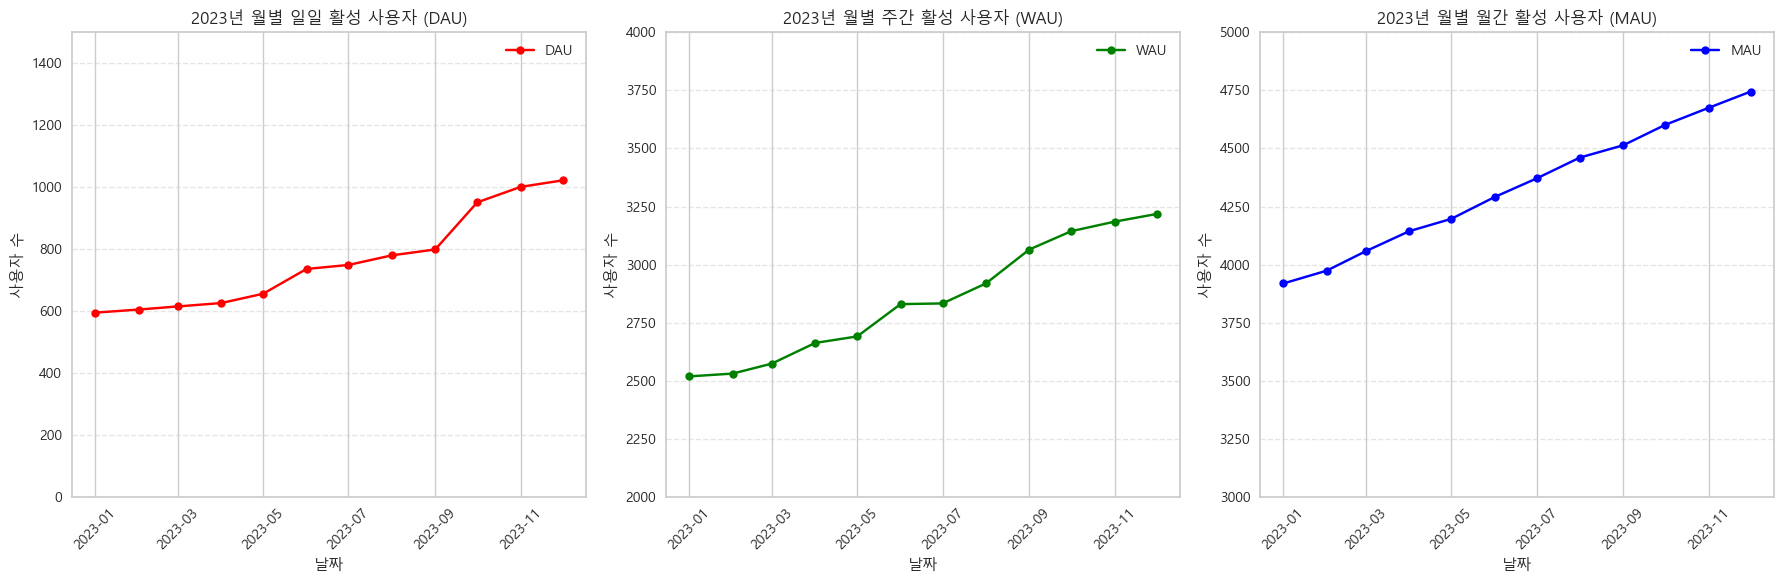

In [27]:
# 월별 시각화
get_monthly_user_plot(login_logs)

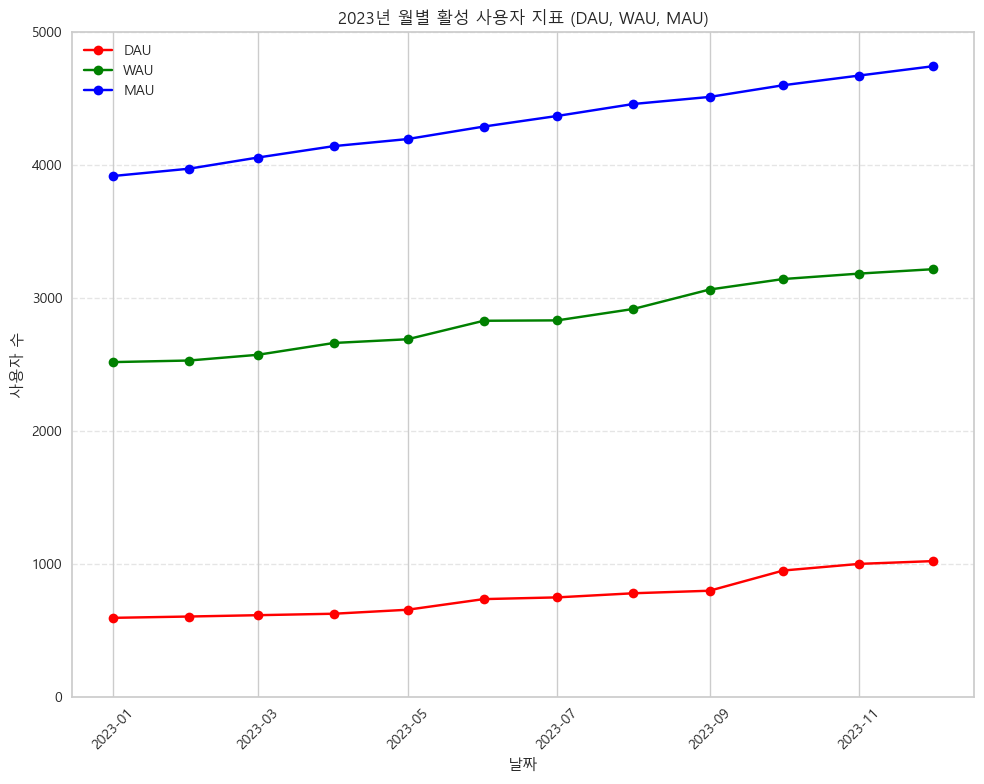

In [28]:
# 결합 시각화
get_combined_user_plot(login_logs)

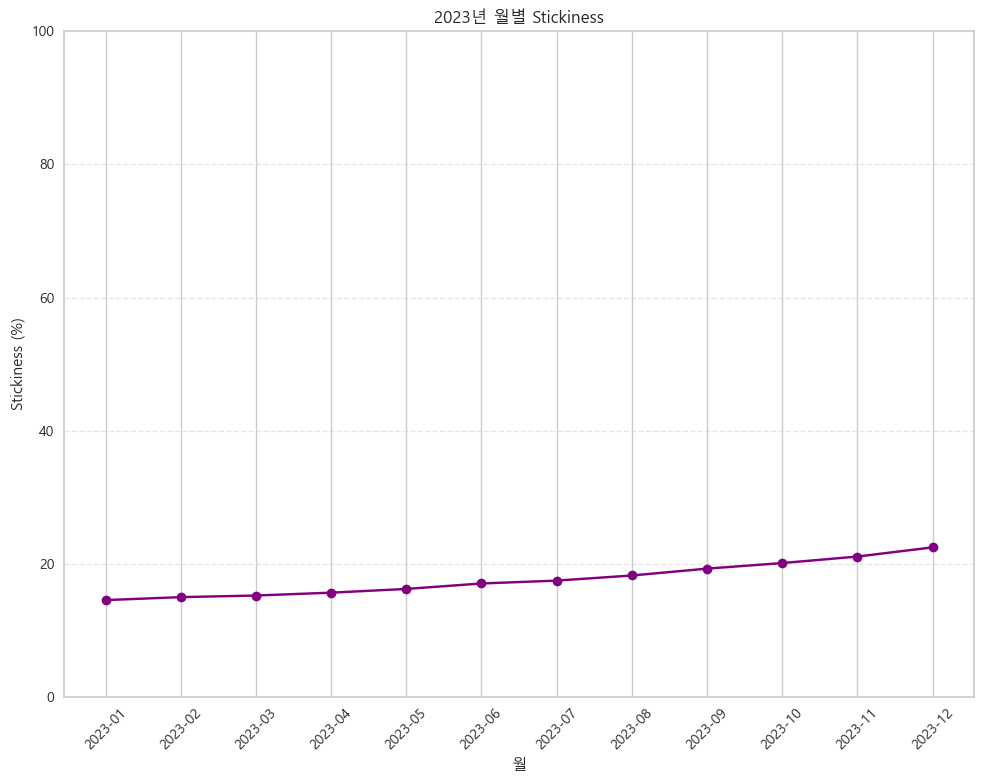

In [29]:
# 월별 DAU와 MAU 계산 함수
def get_monthly_dau_mau(login_logs, year, month):
    # 해당 월의 전체 데이터 필터링
    monthly_logs = login_logs[(login_logs['login_time'].dt.year == year) & (login_logs['login_time'].dt.month == month)]
    
    # MAU 계산
    mau = monthly_logs['user_id'].nunique()
    
    # DAU 계산
    daily_dau = monthly_logs.groupby(monthly_logs['login_time'].dt.date)['user_id'].nunique()
    dau = daily_dau.mean()
    
    return dau, mau

# 2023년 월별 Stickiness
monthly_stickiness = []
for month in range(1, 13):
    dau, mau = get_monthly_dau_mau(login_logs, 2023, month)
    stickiness = (dau / mau) * 100 if mau > 0 else 0
    monthly_stickiness.append(stickiness)

# Stickiness 시각화
plt.figure(figsize=(10, 8))
months = [f"{2023}-{month:02d}" for month in range(1, 13)]
plt.plot(months, monthly_stickiness, marker='o', color='purple')
plt.title("2023년 월별 Stickiness")
plt.xlabel("월")
plt.ylabel("Stickiness (%)")
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('./savefig/04_2023년_Stickiness.png')

In [30]:
# Stickiness 계산

# MAU 계산
mau = get_user_metrics(login_logs, '2023-12-30')['MAU']

# DAU 평균 계산
start_date = pd.to_datetime('2023-12-01').date()
end_date = pd.to_datetime('2023-12-30').date()
daily_dau = [get_user_metrics(login_logs, day)['DAU'] for day in pd.date_range(start=start_date, end=end_date)]
dau = sum(daily_dau) / len(daily_dau)

stickiness = round((dau / mau) * 100, 2)
print("Stickiness:", stickiness, "%")

Stickiness: 22.46 %


---

## 코호트 분석

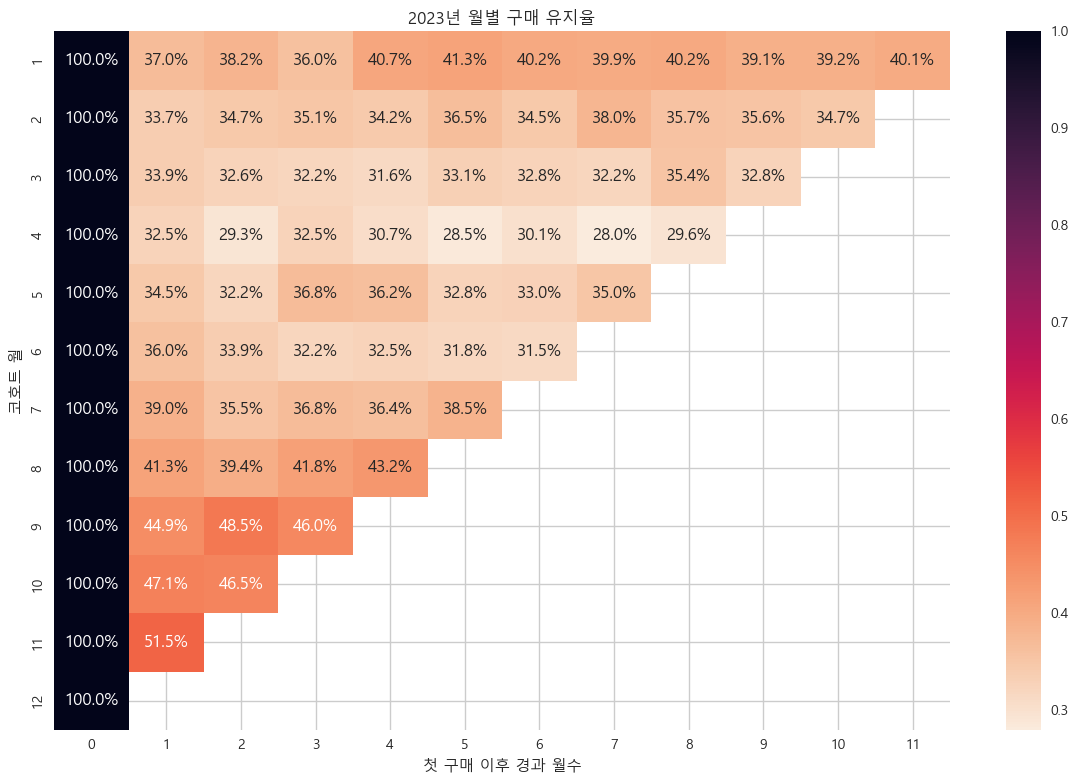

In [31]:
# 2023년 데이터 필터링
cohort = purchase_logs[purchase_logs['purchase_time'].dt.year == 2023].copy()

# 월만 추출하기
cohort['month'] = cohort['purchase_time'].dt.month

# 첫 구매 월별 코호트 생성
cohort['cohort'] = cohort.groupby('user_id')['month'].transform('min')

# 첫 구매 월부터 경과 월수 계산
cohort['since'] = cohort['month'] - cohort['cohort']

# 각 코호트 경과 월수에 해당하는 고객 수 계산
cohort_data = cohort.groupby(['cohort', 'since'])['user_id'].nunique().reset_index()

# 피벗 테이블 생성
cohort_pivot = cohort_data.pivot(index='cohort', columns='since', values='user_id')

# 코호트의 고객 수를 기준으로 유지율을 백분율로 계산
cohort_size = cohort_pivot.iloc[:, 0]
retention_rate = cohort_pivot.divide(cohort_size, axis=0)

# 코호트 분석 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(
    retention_rate, 
    annot=True, 
    fmt=".1%", 
    cmap="rocket_r"
)
plt.title('2023년 월별 구매 유지율')
plt.xlabel('첫 구매 이후 경과 월수')
plt.ylabel('코호트 월')
plt.tight_layout()

# 결과 저장 및 표시
plt.savefig("./savefig/05_코호트분석.png")

---

## 퍼널 분석

로그인 > 상품 페이지 > 장바구니 > 구매 > 재구매

In [32]:
# 2023년 하반기 데이터 필터링
login_logs_2023_h2 = login_logs[(login_logs['login_time'].dt.year == 2023) & (login_logs['login_time'].dt.month >= 7)]
product_view_logs_2023_h2 = product_view_logs[(product_view_logs['view_time'].dt.year == 2023) & (product_view_logs['view_time'].dt.month >= 7)]
cart_logs_2023_h2 = cart_logs[(cart_logs['add_to_cart_time'].dt.year == 2023) & (cart_logs['add_to_cart_time'].dt.month >= 7)]
purchase_logs_2023_h2 = purchase_logs[(purchase_logs['purchase_time'].dt.year == 2023) & (purchase_logs['purchase_time'].dt.month >= 7)]

In [33]:
# 1. 로그인 고객
login_customers = login_logs_2023_h2['user_id'].unique()

# 2. 로그인 고객 중 상품 페이지 방문 고객
viewed_customers = product_view_logs_2023_h2[product_view_logs_2023_h2['user_id'].isin(login_customers)]['user_id'].unique()

# 3. 상품 페이지 방문 고객 중 장바구니에 담은 고객
cart_customers = cart_logs_2023_h2[cart_logs_2023_h2['user_id'].isin(viewed_customers)]['user_id'].unique()

# 4. 장바구니에 담은 고객 중 구매한 고객
purchased_customers = purchase_logs_2023_h2[purchase_logs_2023_h2['user_id'].isin(cart_customers)]['user_id'].unique()

# 5. 구매한 고객 중 2023년 하반기 내에 재구매 한 고객
repurchase_counts = purchase_logs_2023_h2[purchase_logs_2023_h2['user_id'].isin(purchased_customers)]['user_id'].value_counts()
repurchased_customers = repurchase_counts[repurchase_counts >= 2].index

# 각 단계의 고객 수 계산
funnel_data = {
    '단계': ['로그인', '상품 페이지', '장바구니', '구매', '재구매'],
    '전환': [len(login_customers), len(viewed_customers), len(cart_customers), len(purchased_customers), len(repurchased_customers)]
}

funnel_df = pd.DataFrame(funnel_data)
funnel_df['이탈'] = funnel_df['전환'].shift(1) - funnel_df['전환']
funnel_df['이탈'] = funnel_df['이탈'].fillna(0)
funnel_df['전환율'] = (funnel_df['전환'] / funnel_df['전환'].shift(1)) * 100
funnel_df['전환율'] = funnel_df['전환율'].fillna(100)  # 첫 단계 전환율은 100%로 설정
funnel_df['이탈률'] = 100 - funnel_df['전환율']

funnel_df

,단계,전환,이탈,전환율,이탈률
0,로그인,5041,0.0,100.000000,0.000000
1,상품 페이지,4914,127.0,97.480659,2.519341
2,장바구니,4429,485.0,90.130240,9.869760
3,구매,3868,561.0,87.333484,12.666516
4,재구매,2815,1053.0,72.776629,27.223371


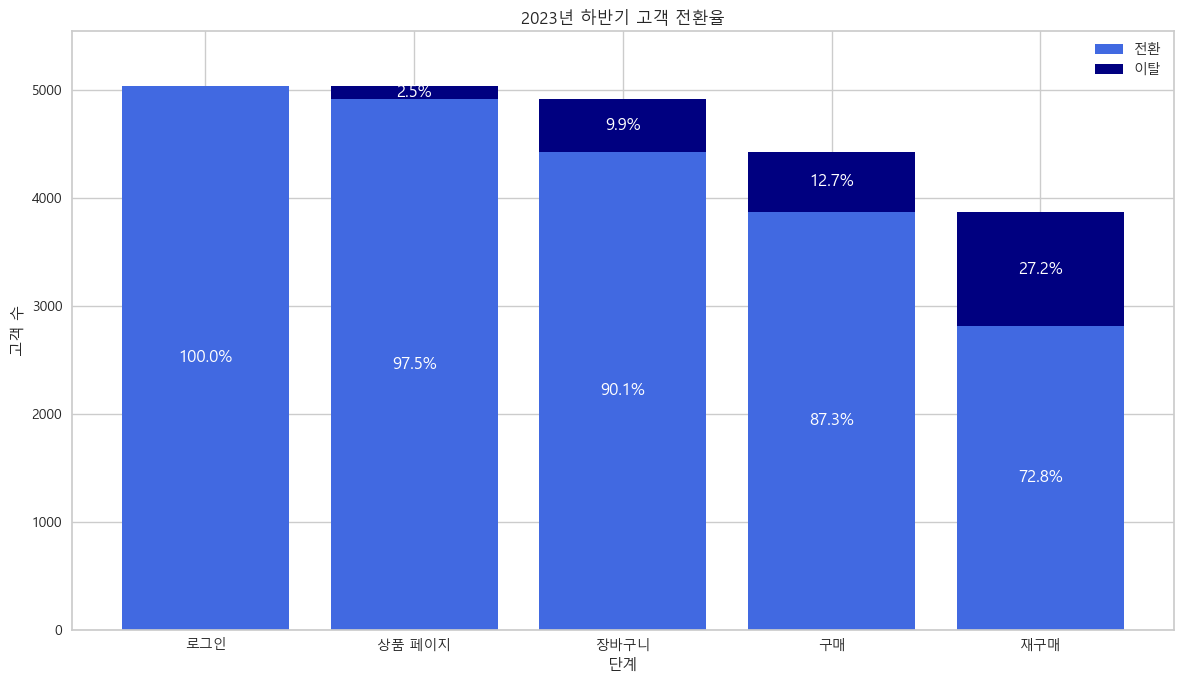

In [34]:
# 퍼널 차트 시각화
plt.figure(figsize=(12, 7))
bar_width = 0.8
x = range(len(funnel_df.index))

# 고객 수 막대
plt.bar(x, funnel_df['전환'], color='royalblue', width=bar_width, label='전환')

# 이탈 수 막대
plt.bar(x, funnel_df['이탈'], bottom=funnel_df['전환'], color='navy', width=bar_width, label='이탈')

# 각 단계에 전환율 및 이탈률 추가
for i in x:
    # 전환율 텍스트
    plt.text(i, funnel_df['전환'][i] / 2, f"{round(funnel_df['전환율'][i], 1)}%", ha='center', va='center', color='white', fontsize=12)
    # 이탈률 텍스트
    if funnel_df['이탈'][i] > 0:
        plt.text(i, funnel_df['전환'][i] + funnel_df['이탈'][i] / 2, f"{round(funnel_df['이탈률'][i], 1)}%", ha='center', va='center', color='white', fontsize=12)

plt.xticks(x, funnel_df['단계'])
plt.ylim(0, max(funnel_df['전환']) * 1.1)
plt.xlabel('단계')
plt.ylabel('고객 수')
plt.title('2023년 하반기 고객 전환율')
plt.legend()
plt.tight_layout()
plt.savefig('./savefig/06_퍼널분석.png')

---

## 가설 수립

### 현재 검증 가능한 가설

#### 1. 맞춤형 알고리즘으로 추천된 상품이 일반 상품보다 장바구니로 더 많이 전환될 것이다.
- 귀무가설(H0): 추천 여부와 장바구니 전환 여부 사이에 연관성이 없다.
- 대립가설(H1): 추천 여부와 장바구니 전환 여부 사이에 연관성이 있다.

In [35]:
# 상품 페이지 뷰와 장바구니 병합
merged_data = pd.merge(
    cart_logs_2023_h2,
    product_view_logs_2023_h2,
    on=['log_id', 'user_id', 'product_id', 'is_recommended'],
    how='right')

# 전체 상품 뷰에서 장바구니로 전환된 비율
total_cart_adds = merged_data['add_to_cart_time'].notna().sum()
overall_cart_conversion_rate = (total_cart_adds / len(merged_data)) * 100
print("전체 상품 뷰 대비 장바구니 전환율: {:.2f}%".format(overall_cart_conversion_rate))

# 추천 상품 뷰에서 장바구니로 전환된 비율
recommended_views = merged_data[merged_data['is_recommended'] == True]
recommended_cart_adds = recommended_views['add_to_cart_time'].notna().sum()
recommended_cart_conversion_rate = (recommended_cart_adds / len(recommended_views)) * 100
print("추천 상품 뷰 대비 장바구니 전환율: {:.2f}%".format(recommended_cart_conversion_rate))

# 추천 없는 일반 상품 뷰에서 장바구니로 전환된 비율
not_recommended_views = merged_data[merged_data['is_recommended'] == False]
not_recommended_cart_adds = not_recommended_views['add_to_cart_time'].notna().sum()
not_recommended_cart_conversion_rate = (not_recommended_cart_adds / len(not_recommended_views)) * 100
print("일반 상품 뷰 대비 장바구니 전환율: {:.2f}%".format(not_recommended_cart_conversion_rate))

전체 상품 뷰 대비 장바구니 전환율: 30.97%
추천 상품 뷰 대비 장바구니 전환율: 30.76%
일반 상품 뷰 대비 장바구니 전환율: 31.09%


In [36]:
from scipy.stats import chi2_contingency

# 전체 상품 뷰에서 장바구니로 전환된 비율
total_views = len(merged_data)
total_cart_adds = merged_data['add_to_cart_time'].notna().sum()

# 추천 상품 뷰와 장바구니로의 전환 여부
recommended_views = merged_data[merged_data['is_recommended'] == True]
not_recommended_views = merged_data[merged_data['is_recommended'] == False]

# 추천 상품과 일반 상품에 대한 장바구니 전환 여부 집계
recommended_cart_adds = recommended_views['add_to_cart_time'].notna().sum()
not_recommended_cart_adds = not_recommended_views['add_to_cart_time'].notna().sum()

# 각 그룹의 전체 뷰 수
total_recommended_views = len(recommended_views)
total_not_recommended_views = len(not_recommended_views)

# 카이제곱 검정을 위한 데이터 준비: 전환된 수와 전환되지 않은 수
contingency_table = [
    [recommended_cart_adds, total_recommended_views - recommended_cart_adds],
    [not_recommended_cart_adds, total_not_recommended_views - not_recommended_cart_adds]
]

# 카이제곱 검정 수행
chi2, p, dof, expected = chi2_contingency(contingency_table)

# 결과 출력
print("카이제곱 통계량:", chi2)
print("p-value:", p)

# 유의수준 0.05를 기준으로 가설 검정
alpha = 0.05
if p < alpha:
    print("추천 여부와 장바구니 전환 여부 사이에 연관성이 있음")
else:
    print("추천 여부와 장바구니 전환 여부 사이에 연관성이 없음")

카이제곱 통계량: 1.8977481965418468
p-value: 0.16833058418469452
추천 여부와 장바구니 전환 여부 사이에 연관성이 없음


- 추천된 상품이 장바구니에 추가될 가능성을 높이지 않는다는 의미이며 추천 시스템이 고객의 장바구니 전환에 유의미한 영향을 미치지 않는 상태이다.
- 일반적으로 추천 시스템은 고객의 장바구니 전환율을 높이기 위해 사용하는데 이러한 결과가 나왔다는 것은 추천 시스템의 효과성을 재점검할 필요가 있다.

#### 2. 첫 구매한 고객 중, 모바일 앱을 통해 구매한 고객은 웹을 통해 구매한 고객보다 한달 내 재구매율이 높을 것이다.

In [37]:
# 구매 내역 테이블 병합
purchase_order_details_2023_h2 = pd.merge(purchase_logs_2023_h2, order_details, on='purchase_id', how='inner')

# 구매 내역과 장바구니 테이블 병합
merged_data = pd.merge(
    cart_logs_2023_h2,
    purchase_order_details_2023_h2,
    on=['user_id', 'product_id', 'quantity'],
    how='right'
)

# 장바구니 담기가 구매보다 먼저인 것만 추출
merged_data = merged_data[merged_data['purchase_time'] > merged_data['add_to_cart_time']]

# 상품이랑 수량이 같으면 마지막에 담은 장바구니 내역만 남기기
merged_data = merged_data.drop_duplicates(subset=['user_id', 'product_id', 'quantity', 'purchase_time'], keep='last')

In [38]:
# 신규 회원의 첫 구매 정보 추출
first_purchases = merged_data[merged_data['user_id'].isin(users['user_id'])]
first_purchases = first_purchases.sort_values(by=['user_id', 'purchase_time']).drop_duplicates(subset='user_id', keep='first')

# 한 달 내 재구매 여부 판별을 위해 사용자별 구매 횟수 및 첫 구매 날짜 이후 구매 내역 계산
merged_data['within_one_month'] = merged_data['purchase_time'] <= (merged_data['purchase_time'] + pd.DateOffset(months=1))

# 기기 유형별로 나누기
mobile_users = first_purchases[first_purchases['device_type'] == 'Mobile']['user_id']
desktop_users = first_purchases[first_purchases['device_type'] == 'Desktop']['user_id']

# 재구매율 계산 함수
def calculate_repurchase_rate(user_ids):
    user_purchase_counts = merged_data[merged_data['user_id'].isin(user_ids)]['user_id'].value_counts()
    return (user_purchase_counts > 1).mean() * 100

# 모바일과 데스크탑 사용자 재구매율 계산
mobile_purchase_counts = merged_data[merged_data['user_id'].isin(mobile_users)]['user_id'].value_counts()
mobile_repurchase_rate = (mobile_purchase_counts > 1).mean() * 100

desktop_purchase_counts = merged_data[merged_data['user_id'].isin(desktop_users)]['user_id'].value_counts()
desktop_repurchase_rate = (desktop_purchase_counts > 1).mean() * 100

# 전체 재구매율 계산
user_purchase_counts = merged_data[merged_data['user_id'].isin(first_purchases['user_id'])]['user_id'].value_counts()
total_repurchase_rate = (user_purchase_counts > 1).mean() * 100

# 결과 출력
print("모바일 앱을 통해 첫 구매한 고객의 한 달 내 재구매율: {:.2f}%".format(mobile_repurchase_rate))
print("데스크탑을 통해 첫 구매한 고객의 한 달 내 재구매율: {:.2f}%".format(desktop_repurchase_rate))
print("전체 첫 구매한 고객의 한 달 내 재구매율: {:.2f}%".format(total_repurchase_rate))

모바일 앱을 통해 첫 구매한 고객의 한 달 내 재구매율: 76.00%
데스크탑을 통해 첫 구매한 고객의 한 달 내 재구매율: 73.84%
전체 첫 구매한 고객의 한 달 내 재구매율: 74.92%


In [39]:
# 모바일 사용자와 데스크탑 사용자의 재구매 여부 데이터 생성
mobile_repurchase = [
    (merged_data[merged_data['user_id'].isin(mobile_users)]['user_id'].value_counts() > 1).sum(),
    (merged_data[merged_data['user_id'].isin(mobile_users)]['user_id'].value_counts() <= 1).sum()
]

desktop_repurchase = [
    (merged_data[merged_data['user_id'].isin(desktop_users)]['user_id'].value_counts() > 1).sum(),
    (merged_data[merged_data['user_id'].isin(desktop_users)]['user_id'].value_counts() <= 1).sum()
]

# 카이제곱 검정을 위한 교차표 생성
contingency_table = [mobile_repurchase, desktop_repurchase]

# 카이제곱 검정 수행
chi2, p, dof, expected = chi2_contingency(contingency_table)

# 결과 출력
print("카이제곱 통계량:", chi2)
print("p-value:", p)

# 유의수준 0.05를 기준으로 가설 검정
alpha = 0.05
if p < alpha:
    print("모바일을 통한 첫 구매 고객과 데스크탑을 통한 첫 구매 고객 간의 한 달 내 재구매율에 차이가 있음")
else:
    print("모바일을 통한 첫 구매 고객과 데스크탑을 통한 첫 구매 고객 간의 한 달 내 재구매율에 차이가 없음")

카이제곱 통계량: 2.2489025922824
p-value: 0.13370919583926863
모바일을 통한 첫 구매 고객과 데스크탑을 통한 첫 구매 고객 간의 한 달 내 재구매율에 차이가 없음


#### 3. 고객을 세분화하여 이탈률을 확인해보면 특정 그룹에서 구매 단계의 이탈률이 높을 것이다.

3-1. 고객 세분화

RFM 프레임워크를 활용한 K-means 클러스터링으로 고객 세분화 진행

- Recency: 2023-12-31 기준으로 최근 1개월 내 구매 여부
- Frequency: 2023년 총 주문 건수
- Monetary: 2023년 총 주문 금액
- 2023년에 주문 기록이 없는 고객은 마지막 군집으로 분류하여 휴면 고객으로 간주

In [40]:
# 2023년 데이터 필터링
purchase_logs_2023 = purchase_logs[purchase_logs['purchase_time'].dt.year == 2023].copy()

# R, F, M 계산
# Recency: 2023-12-31 기준으로 최근 1개월 내 구매 여부
purchase_logs_2023_12 = purchase_logs_2023[(purchase_logs_2023['purchase_time'].dt.month >= 12)]
recent_purchase_users = purchase_logs_2023_12['user_id'].unique()

# Recency 컬럼 생성
recency = pd.DataFrame({'user_id': purchase_logs_2023['user_id'].unique()})
recency['recency'] = recency['user_id'].isin(recent_purchase_users)

# Frequency: 2023년 주문 건수
frequency = purchase_logs_2023.groupby('user_id').size().reset_index(name='frequency')

# Monetary: 2023년 주문 금액 합계
monetary = purchase_logs_2023.groupby('user_id')['total_amount'].sum().reset_index(name='monetary')

# 데이터 병합
rfm_df = recency.merge(frequency, on='user_id', how='left')
rfm_df = rfm_df.merge(monetary, on='user_id', how='left')

# 결과 확인
rfm_df.head()

,user_id,recency,frequency,monetary
0,1804,False,5,1516.96
1,2421,False,7,1103.32
2,1965,True,2,418.84
3,259,False,3,2620.60
4,840,True,27,6338.94


KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=9, n_init=10),
                 k=(1, 10))

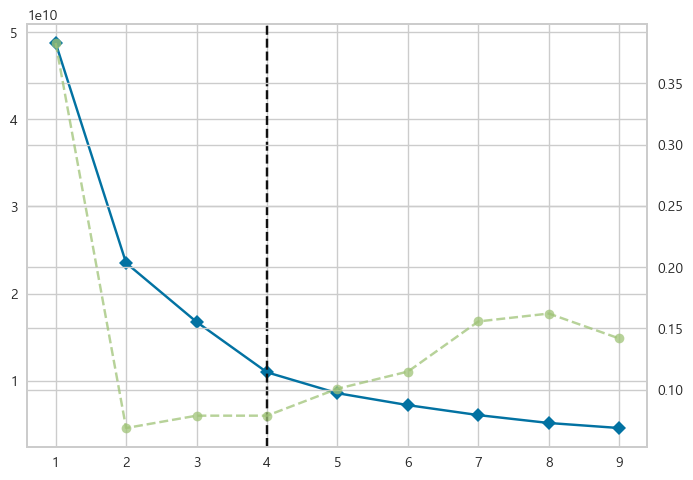

In [41]:
# 엘보우 기법
model = KMeans(n_init=10)
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(rfm_df)

In [42]:
# RFM 데이터 표준화 (scaling)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['recency', 'frequency', 'monetary']])

# 모델생성
km = KMeans(n_clusters=4, n_init=10, random_state=1)

# 훈련
km.fit(rfm_scaled)

# 군집 결과 확인
rfm_df = rfm_df.copy()
rfm_df.loc[:, 'clust'] = km.labels_

np.unique(km.labels_, return_counts=True)

(array([0, 1, 2, 3]), array([2632,  543,  125, 1186], dtype=int64))

In [43]:
# 실루엣 계수
silhouette_avg = silhouette_score(rfm_scaled, km.labels_)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.6255878341993583


In [44]:
# Kmeans 군집 결과
rfm_df.head()

,user_id,recency,frequency,monetary,clust
0,1804,False,5,1516.96,0
1,2421,False,7,1103.32,0
2,1965,True,2,418.84,3
3,259,False,3,2620.60,0
4,840,True,27,6338.94,1


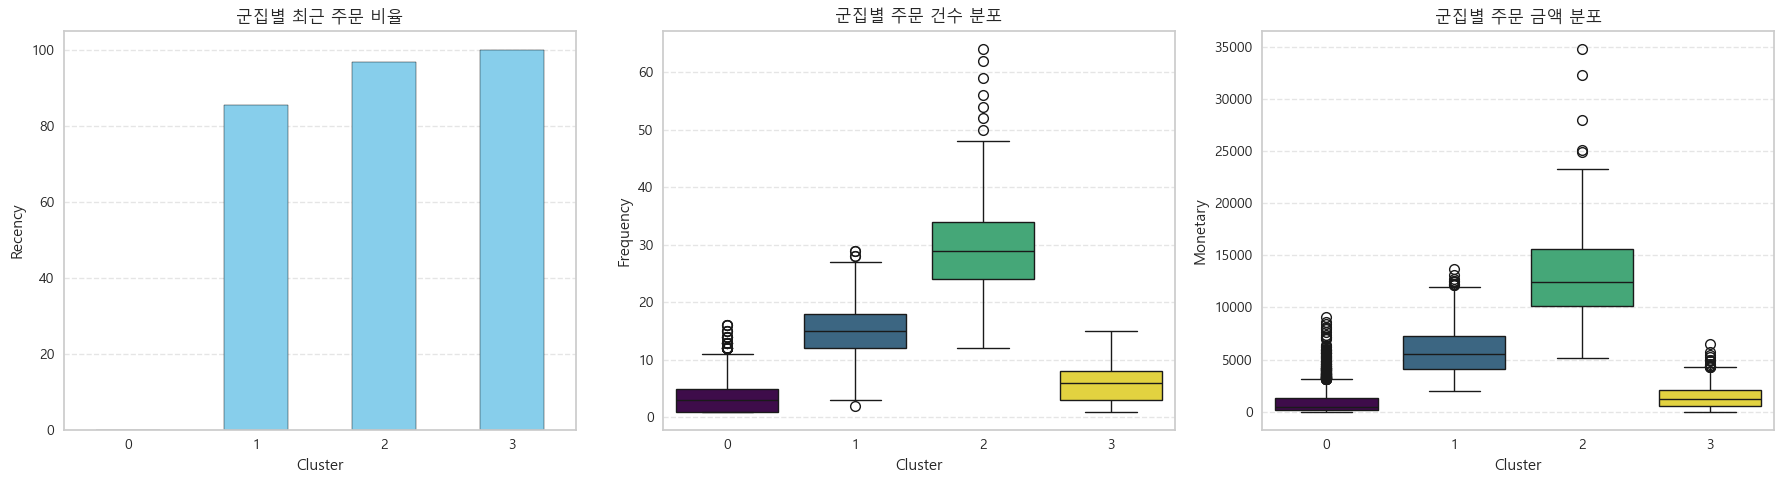

In [45]:
# 그래프 크기 설정
plt.figure(figsize=(18, 5))

# 1. 군집별 최근 주문 비율 bar
plt.subplot(1, 3, 1)
recent_order_rate = rfm_df.groupby('clust')['recency'].mean() * 100
recent_order_rate.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('군집별 최근 주문 비율')
plt.xlabel('Cluster')
plt.ylabel('Recency')
plt.xticks(rotation=0)
plt.gca().xaxis.grid(False)  # x축 격자선 제거
plt.grid(axis='y', linestyle='--', alpha=0.5)

# 2. 군집별 주문 건수 분포
plt.subplot(1, 3, 2)
sns.boxplot(x='clust', y='frequency', data=rfm_df, palette='viridis', hue='clust', dodge=False)
plt.title('군집별 주문 건수 분포')
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.legend([], [], frameon=False) 
plt.grid(axis='y', linestyle='--', alpha=0.5)

# 3. 군집별 주문 금액 분포
plt.subplot(1, 3, 3)
sns.boxplot(x='clust', y='monetary', data=rfm_df, palette='viridis', hue='clust', dodge=False)
plt.title('군집별 주문 금액 분포')
plt.xlabel('Cluster')
plt.ylabel('Monetary')
plt.legend([], [], frameon=False)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# 레이아웃 조정 및 그래프 출력
plt.tight_layout()
plt.savefig('./savefig/07_고객세분화_rfm_시각화.png')

- 군집 0: 주문 빈도와 금액이 모두 낮아 비활성 고객 또는 저가 구매자로 분류될 수 있음.
- 군집 1: 중간 정도의 구매 빈도와 금액을 보이며 적당히 활동적이고 일정한 구매력을 가진 고객층.
- 군집 2: 모든 지표에서 높은 수치를 보이며 주문 금액이 높고 매우 활발한 프리미엄 고객층.
- 군집 3: 최근 주문 비율이 높으나 주문 빈도와 금액이 낮아 일시적인 활성 고객으로 분류될 수 있음.
- 군집 4: 2023년 동안 구매 내역이 없는 고객. (클러스터링에서는 제외됨)

3-2. 고객 군집별 퍼널 분석

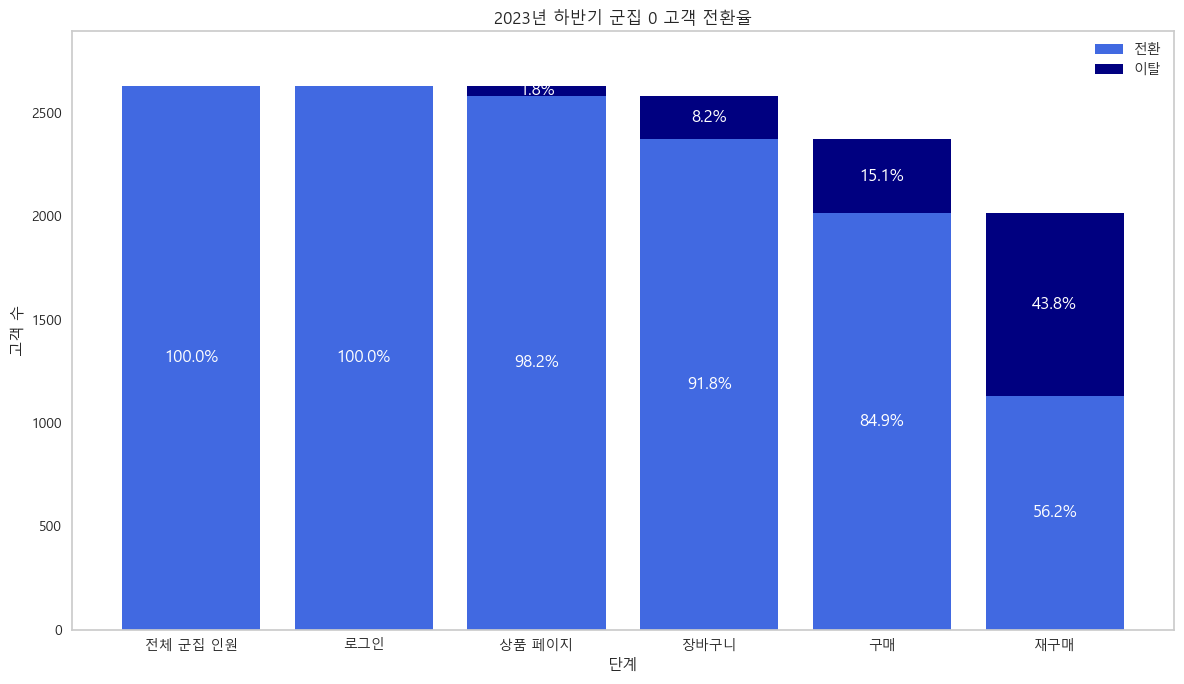

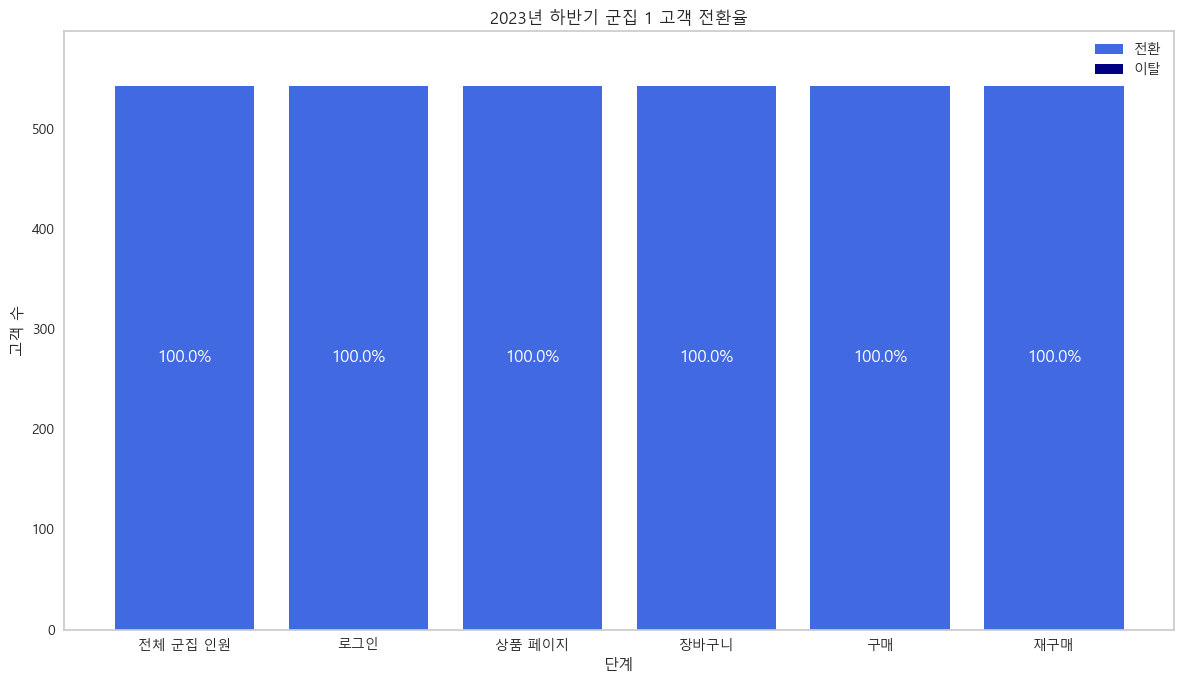

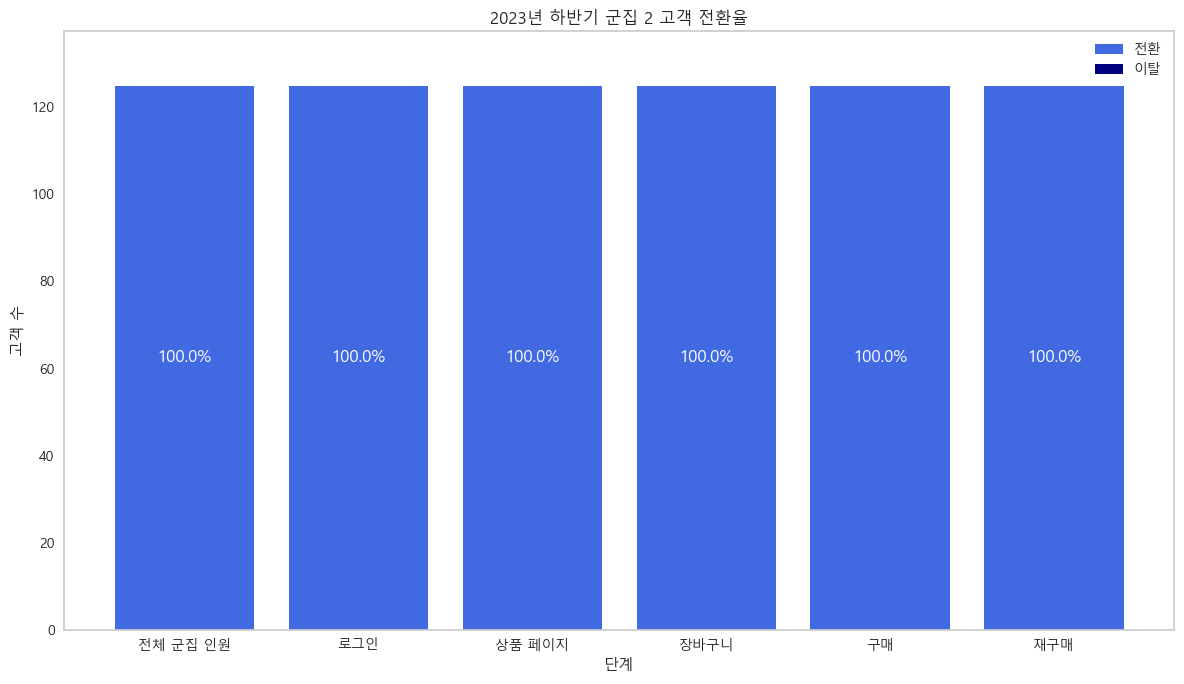

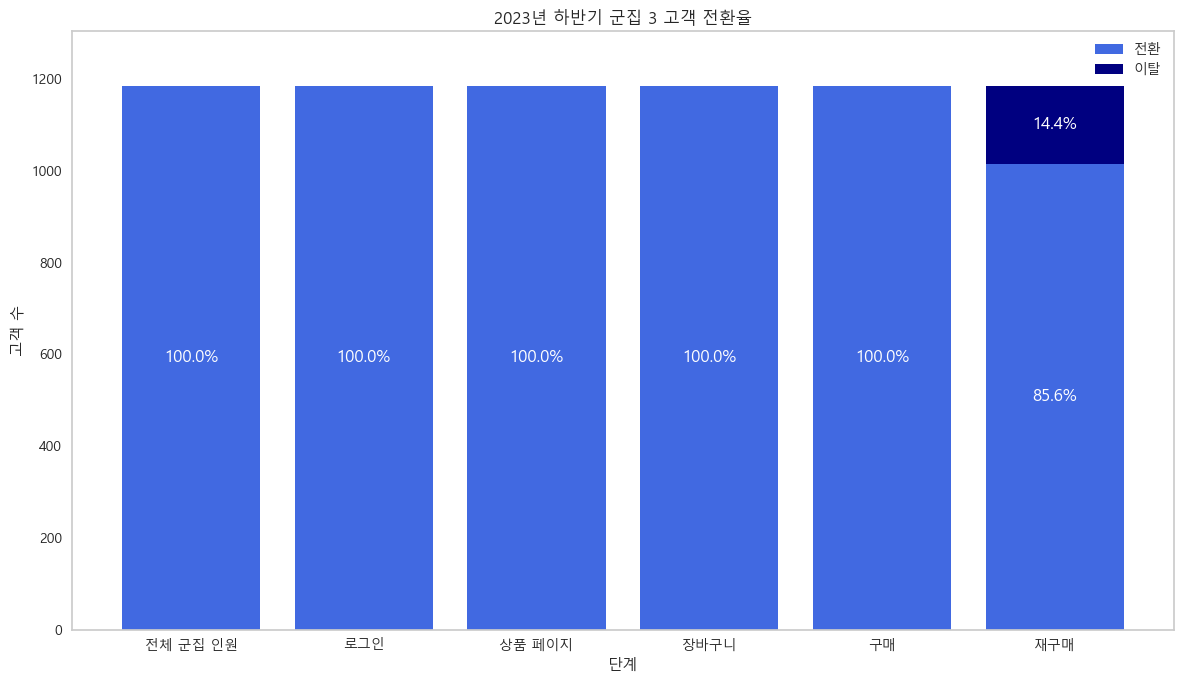

In [46]:
# 각 군집에 대한 퍼널 분석을 수행
for cluster in sorted(rfm_df['clust'].unique()):
    # 각 군집의 고객 데이터 필터링
    cluster_users = rfm_df[rfm_df['clust'] == cluster]['user_id'].unique()

    # 1. 전체 군집 인원
    total_cluster_customers = len(cluster_users)

    # 2. 2023년 하반기 로그인 고객
    login_customers = login_logs_2023_h2[login_logs_2023_h2['user_id'].isin(cluster_users)]['user_id'].unique()

    # 3. 로그인 고객 중 상품 페이지 방문 고객
    viewed_customers = product_view_logs_2023_h2[product_view_logs_2023_h2['user_id'].isin(login_customers)]['user_id'].unique()

    # 4. 상품 페이지 방문 고객 중 장바구니에 담은 고객
    cart_customers = cart_logs_2023_h2[cart_logs_2023_h2['user_id'].isin(viewed_customers)]['user_id'].unique()

    # 5. 장바구니에 담은 고객 중 구매한 고객
    purchased_customers = purchase_logs_2023_h2[purchase_logs_2023_h2['user_id'].isin(cart_customers)]['user_id'].unique()

    # 6. 구매한 고객 중 2023년 하반기 내에 재구매한 고객
    repurchase_counts = purchase_logs_2023_h2[purchase_logs_2023_h2['user_id'].isin(purchased_customers)]['user_id'].value_counts()
    repurchased_customers = repurchase_counts[repurchase_counts >= 2].index

    # 각 단계의 고객 수 계산
    funnel_data = {
        '단계': ['전체 군집 인원', '로그인', '상품 페이지', '장바구니', '구매', '재구매'],
        '전환': [
            total_cluster_customers,
            len(login_customers),
            len(viewed_customers),
            len(cart_customers),
            len(purchased_customers),
            len(repurchased_customers)
        ]
    }

    # 데이터프레임으로 변환하여 전환율 및 이탈률 계산
    funnel_df = pd.DataFrame(funnel_data)
    funnel_df['이탈'] = funnel_df['전환'].shift(1) - funnel_df['전환']
    funnel_df['이탈'] = funnel_df['이탈'].fillna(0)
    funnel_df['전환율'] = (funnel_df['전환'] / funnel_df['전환'].shift(1)) * 100
    funnel_df['전환율'] = funnel_df['전환율'].fillna(100)  # 첫 단계 전환율은 100%로 설정
    funnel_df['이탈률'] = 100 - funnel_df['전환율']

    # 퍼널 차트 시각화
    plt.figure(figsize=(12, 7))
    bar_width = 0.8
    x = range(len(funnel_df.index))

    # 고객 수 막대
    plt.bar(x, funnel_df['전환'], color='royalblue', width=bar_width, label='전환')

    # 이탈 수 막대
    plt.bar(x, funnel_df['이탈'], bottom=funnel_df['전환'], color='navy', width=bar_width, label='이탈')

    # 각 단계에 전환율 및 이탈률 추가
    for i in x:
        # 전환율 텍스트
        plt.text(i, funnel_df['전환'][i] / 2, f"{round(funnel_df['전환율'][i], 1)}%", ha='center', va='center', color='white', fontsize=12)
        # 이탈률 텍스트
        if funnel_df['이탈'][i] > 0:
            plt.text(i, funnel_df['전환'][i] + funnel_df['이탈'][i] / 2, f"{round(funnel_df['이탈률'][i], 1)}%", ha='center', va='center', color='white', fontsize=12)

    plt.xticks(x, funnel_df['단계'])
    plt.ylim(0, max(funnel_df['전환']) * 1.1)
    plt.xlabel('단계')
    plt.ylabel('고객 수')
    plt.title(f'2023년 하반기 군집 {cluster} 고객 전환율')
    plt.legend()
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(f'./savefig/06_퍼널분석_군집_{cluster}.png')
    plt.show()

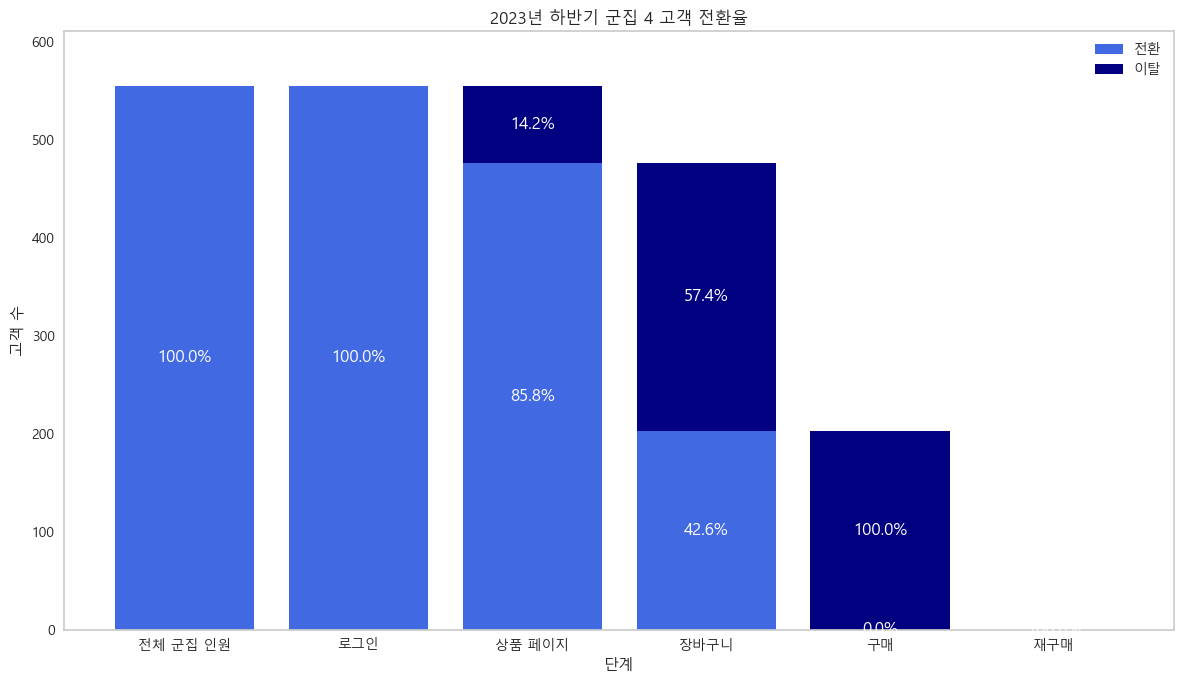

In [47]:
# 전체 고객 목록에서 rfm_df에 포함되지 않은 고객을 추출하여 군집 4로 간주
all_customers = users['user_id'].unique()
active_customers = rfm_df['user_id'].unique()
dormant_customers = list(set(all_customers) - set(active_customers))

# 2023년 하반기 군집 4 고객의 데이터 필터링
dormant_login_customers = login_logs_2023_h2[login_logs_2023_h2['user_id'].isin(dormant_customers)]['user_id'].unique()
dormant_viewed_customers = product_view_logs_2023_h2[product_view_logs_2023_h2['user_id'].isin(dormant_login_customers)]['user_id'].unique()
dormant_cart_customers = cart_logs_2023_h2[cart_logs_2023_h2['user_id'].isin(dormant_viewed_customers)]['user_id'].unique()
dormant_purchased_customers = purchase_logs_2023_h2[purchase_logs_2023_h2['user_id'].isin(dormant_cart_customers)]['user_id'].unique()
dormant_repurchase_counts = purchase_logs_2023_h2[purchase_logs_2023_h2['user_id'].isin(dormant_purchased_customers)]['user_id'].value_counts()
dormant_repurchased_customers = dormant_repurchase_counts[dormant_repurchase_counts >= 2].index

# 각 단계의 고객 수 계산
dormant_funnel_data = {
    '단계': ['전체 군집 인원', '로그인', '상품 페이지', '장바구니', '구매', '재구매'],
    '전환': [len(dormant_customers), len(dormant_login_customers), len(dormant_viewed_customers), len(dormant_cart_customers), len(dormant_purchased_customers), len(dormant_repurchased_customers)]
}

dormant_funnel_df = pd.DataFrame(dormant_funnel_data)
dormant_funnel_df['이탈'] = dormant_funnel_df['전환'].shift(1) - dormant_funnel_df['전환']
dormant_funnel_df['이탈'] = dormant_funnel_df['이탈'].fillna(0)
dormant_funnel_df['전환율'] = (dormant_funnel_df['전환'] / dormant_funnel_df['전환'].shift(1)) * 100
dormant_funnel_df['전환율'] = dormant_funnel_df['전환율'].fillna(100)  # 첫 단계 전환율은 100%로 설정
dormant_funnel_df['이탈률'] = 100 - dormant_funnel_df['전환율']

# 퍼널 차트 시각화
plt.figure(figsize=(12, 7))
bar_width = 0.8
x = range(len(dormant_funnel_df.index))

# 고객 수 막대
plt.bar(x, dormant_funnel_df['전환'], color='royalblue', width=bar_width, label='전환')

# 이탈 수 막대
plt.bar(x, dormant_funnel_df['이탈'], bottom=dormant_funnel_df['전환'], color='navy', width=bar_width, label='이탈')

# 각 단계에 전환율 및 이탈률 추가
for i in x:
    plt.text(i, dormant_funnel_df['전환'][i] / 2, f"{round(dormant_funnel_df['전환율'][i], 1)}%", ha='center', va='center', color='white', fontsize=12)
    if dormant_funnel_df['이탈'][i] > 0:
        plt.text(i, dormant_funnel_df['전환'][i] + dormant_funnel_df['이탈'][i] / 2, f"{round(dormant_funnel_df['이탈률'][i], 1)}%", ha='center', va='center', color='white', fontsize=12)

plt.xticks(x, dormant_funnel_df['단계'])
plt.ylim(0, max(dormant_funnel_df['전환']) * 1.1)
plt.xlabel('단계')
plt.ylabel('고객 수')
plt.title('2023년 하반기 군집 4 고객 전환율')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.savefig('./savefig/06_퍼널분석_군집_4.png')
plt.show()

#### 유저 수
- 전체: 5041
- 군집 0: 2631
- 군집 1: 543
- 군집 2: 125
- 군집 3: 1186
- 군집 4: 560

1. **군집 0**: 장바구니에서 구매, 재구매 과정에서 일부 이탈이 발생. 이 군집은 주문 빈도와 금액이 낮고 최근 구매 이력이 적어 충성 고객이라 보기 어려움.
    - 추천 액션: 관심을 유지할 수 있도록 소액 할인 쿠폰이나 특별 프로모션 제공을 통해 구매를 유도하고, 장바구니에 담긴 상품을 기반으로 맞춤형 알림을 제공해 전환을 유도.
2. **군집 1, 2**: 모든 퍼널 단계에서 이탈이 없어 높은 충성도를 보이는 고객군.
    - 추천 액션: 고객의 충성도를 더욱 강화하기 위해 멤버십 프로그램이나 VIP 혜택을 도입하는 방안을 고려.
3. **군집 3**: 재구매 단계에서 약간의 이탈이 있었으나 최근 한 달 내에 구매가 이루어진 비교적 활성화된 집단.
    - 추천 액션: 재구매 전환율을 높이기 위해 구매 후 한 달 이내에 사용할 수 있는 할인 코드 제공이나 재방문 시점에 맞춘 프로모션을 실시하여 반복 구매를 장려.
4. **군집 4**: 2023년 구매 내역은 없지만 상품 페이지까지 방문한 고객이 85%. 하지만 장바구니 전환율이 42%로 떨어지며 구매로 전환된 것은 0%.
    - 추천 액션: 휴면 고객의 이탈 원인을 파악하기 위해 이 군집의 상품 페이지 방문 이후 행동을 분석. 상품 페이지에서 장바구니로 전환되지 않는 이유가 특정한 상품의 가격, 상품 설명, 배송비 등의 문제인지 파악하고 장바구니 전환율 개선을 위해 특정 상품군에 할인 혜택을 제공하거나 방문 후 이탈 고객을 대상으로 리마케팅 캠페인을 실시하는 방안을 고려.